In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Model for a moulin feeding three conduits that join at different locations along the center conduit
from scipy.integrate import odeint
from scipy.optimize import brentq

# Constants - unchanging
rho_w = 1000.#density of water, kg/m^3
rho_i = 900#density of ice, kg/m^3
L_f = 3.34e5#Latent heat of fusion (ice), J/kg
n=3.#ice flow law exponent, unitless
B=5.8e7#Arrhenius parameter, N/m^2 *s^(1/n)
f=0.1#Darcy-Weisbach friction factor, unitless
g = 9.8#gravitational accel, m^2/s
P = 24.*3600. # Period - 1 day in seconds

In [3]:
# Functions
def R(ti,Ri):
    P=24.*3600.
    return Ri*(1.+sin(2.*pi*ti/P)/2.)

def P_wet(A):
    return 2.*sqrt(pi*A)#2.*A**2./pi
def D_H(A):
    return 4.*A/P_wet(A)

def C(A,L):
    return A*sqrt(2.*g/(1+f*L/D_H(A)))

# calculate head for three conduits
def fh3(h3, h1, C13,C14,C23,C34):
    #flow conservation at junction, used to calculate h3 via minimization
    return C13*sqrt(abs(h1-h3))*sign(h1-h3) + C14*sqrt(abs(h1-h3))*sign(h1-h3) + C23*sqrt(abs(h1-h3))*sign(h1-h3) - C34*sqrt(h3)

# three conduits
def dy_dt3(y,ti,Recharge,Zi):
    #Ri = args[0]
    Pi = rho_i*g*Zi
    h1 = y[0]
    A1 = y[1]
    A2 = y[2]
    A3 = y[3]
    A_merg = y[4]
    C1 = C(A1,L1)
    C2 = C(A2,L2)
    C3 = C(A3,L3)
    C_merg = C(A_merg,L_merg)
    h3 = brentq(fh3, 0,10000, args=(h1,C1,C2,C3,C_merg))
    #print h1,h3
    Q1 = C1*sqrt(abs(h1-h3))*sign(h1-h3)
    Q2 = C2*sqrt(abs(h1-h3))*sign(h1-h3)
    Q3 = C3*sqrt(abs(h1-h3))*sign(h1-h3)
    Q_merg = C_merg*sqrt(abs(h3))
    P = 24.*3600.
    dh1_dt = (Recharge*(1.+sin(2.*pi*ti/P)/2.) - Q1 - Q2 - Q3)/A_R
    Pw1 = rho_w*g*(h1+h3)/2.
    Pw2 = rho_w*g*(h1+h3)/2.
    Pw3 = rho_w*g*(h1+h3)/2.
    Pw_merg = rho_w*g*(h3)
    dA1_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A1)*(abs(Q1)/A1)**3 - 2.*(1./(n*B))**n*A1*(Pi-Pw1)*abs(Pi-Pw1)**(n-1.)
    dA2_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A2)*(abs(Q2)/A2)**3 - 2.*(1./(n*B))**n*A2*(Pi-Pw2)*abs(Pi-Pw2)**(n-1.)
    dA3_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A3)*(abs(Q3)/A3)**3 - 2.*(1./(n*B))**n*A3*(Pi-Pw3)*abs(Pi-Pw3)**(n-1.)
    dAmerg_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A_merg)*(abs(Q_merg)/A_merg)**3 - 2.*(1./(n*B))**n*A_merg*(Pi-Pw_merg)*abs(Pi-Pw_merg)**(n-1.)
    return [dh1_dt, dA1_dt, dA2_dt, dA3_dt, dAmerg_dt]




Max Head = 750.0 Min Head = 28.8861269799
Average Recharge = 2.5 Moulin Area = 100 Ice thickness = 1000


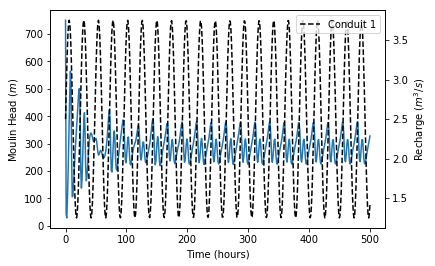

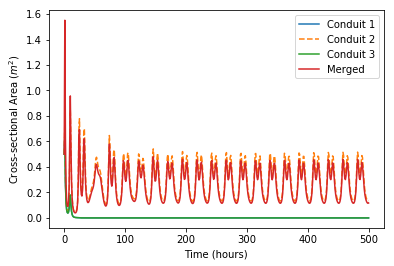

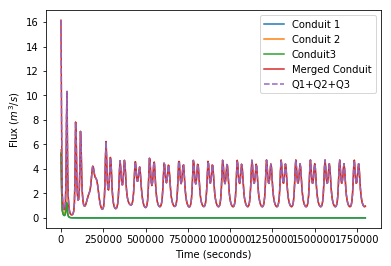

In [16]:
# Investigating: minimum hydraulic diameter neccessary
# Changing:

# Clear variables that change
# Changing ---- 3 conduit below --------
L1=500 # Length of conduit 1
L2=450 # Length of conduit 2
L3=500 # Length of conduit 3
L_merg=50 # Length of merged conduit
A0_1=0.5 # Starting Ac of conduit 1
A0_2=0.5 # Starting Ac of conduit 2
A0_3=0.5 # Starting Ac of conduit 3
A0_merg=0.5 # Starting Ac of merged conduit
h0=750 # head in moulin (start)
Recharge=2.5 # Average recharge to moulin
A_R=100 # Moulin cross sectional area
Z=1000 # Ice thickness


# Run model with above specification
nhours = 500
nsecs = nhours*60*60
t = linspace(0,nsecs,500)

sol3= odeint(dy_dt3, [h0,A0_1,A0_2,A0_3,A0_merg], t, args=(Recharge,Z))

Rec = Recharge*(1.+sin(2.*pi*t/P)/2.) #define recharge for plotting

hmax1=max(sol3[:,0])

# print model run specifications
print 'Max Head =',hmax1, 'Min Head =',min(sol3[:,0])
print 'Average Recharge =',Recharge,'Moulin Area =',A_R,'Ice thickness =',Z


# Plotting above version of the model
tplot=t/3600.
fig, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(tplot,sol3[:,0])
ax2.plot(tplot,Rec,'k--')
ax1.set_xlabel("Time (hours)")
ax1.set_ylabel("Moulin Head ($m$)")
ax2.set_ylabel("Recharge ($m^3/s$)")
legend(['Conduit 1','Conduit 2','Conduit 3','Merged'],loc=1)

figure()
plot(tplot,sol3[:,1])
plot(tplot,sol3[:,2],'--')
plot(tplot,sol3[:,3])
plot(tplot,sol3[:,4])
xlabel("Time (hours)")
ylabel("Cross-sectional Area ($m^2$)")
legend(['Conduit 1','Conduit 2','Conduit 3','Merged'],loc=1)

# CHECK -----
C1 = C(sol3[:,1],L1)
C2 = C(sol3[:,2],L2)
C3 = C(sol3[:,3],L3)
C_merg = C(sol3[:,4],L_merg)
h3 = []
for i,Cblank in enumerate(C1):
    h3.append(brentq(fh3, 0, 10000, args=(sol3[i,0],C1[i],C2[i],C3[i],C_merg[i])))
Q1 = C1*sqrt(abs(sol3[:,0]-h3))*sign(sol3[:,0]-h3)
Q2 = C2*sqrt(abs(sol3[:,0]-h3))*sign(sol3[:,0]-h3)
Q3 = C3*sqrt(abs(sol3[:,0]-h3))*sign(sol3[:,0]-h3)
Q_merg = C_merg*sqrt(array(h3))


figure()
plot(t,Q1,t,Q2,t,Q3,t,Q_merg,t,Q1+Q2+Q3,'--')
legend(['Conduit 1','Conduit 2','Conduit3','Merged Conduit','Q1+Q2+Q3'],loc=1)
xlabel("Time (seconds)")
ylabel("Flux ($m^3/s$)")
%xdel sol3

In [4]:
help(brentq)

Help on function brentq in module scipy.optimize.zeros:

brentq(f, a, b, args=(), xtol=2e-12, rtol=8.8817841970012523e-16, maxiter=100, full_output=False, disp=True)
    Find a root of a function in a bracketing interval using Brent's method.
    
    Uses the classic Brent's method to find a zero of the function `f` on
    the sign changing interval [a , b].  Generally considered the best of the
    rootfinding routines here.  It is a safe version of the secant method that
    uses inverse quadratic extrapolation.  Brent's method combines root
    bracketing, interval bisection, and inverse quadratic interpolation.  It is
    sometimes known as the van Wijngaarden-Dekker-Brent method.  Brent (1973)
    claims convergence is guaranteed for functions computable within [a,b].
    
    [Brent1973]_ provides the classic description of the algorithm.  Another
    description can be found in a recent edition of Numerical Recipes, including
    [PressEtal1992]_.  Another description is at
   